In [150]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Preprossesering av rentedataen
Ettersom dato-kolonnene er ulike for ulike rente-perioder så må vi først justere for dette.

In [152]:
df = pd.read_excel(r"20210922Renter.xlsx")
# data = df.to_numpy()

In [153]:
# computing number of rows
nrows = len(df.axes[0])
  
# computing number of columns
ncols = len(df.axes[1])

# number of series
nseries = int(ncols/2)

#insert columns in new dataframe
d = []
for j in range(0,nseries-1):
    d.append(df.iloc[:,2*j])                # legg til alle dato kolonner for hver serie i en ny liste d

dates = np.sort(np.unique(d))               # plukk ut unike datoer og sorter
dates = np.delete(dates,len(dates)-1)                            
df_final = pd.DataFrame(dates)
df_final.columns = ['dates']

# nseries er 14
for col in range(0,nseries-1):

    temp = np.zeros(nrows)
    
    # sjekk om  dato-kolonner er like eller ei
    if df.iloc[:,2*col].equals(df_final.iloc[:,0]): #2*col gir dato-kolonne i df
        
        df_final.insert(col+1 , df.columns[2*col+1] , df.iloc[:,2*col+1]) #2*col+1 gir verdi-kolonne i df
    
    else:
        # iterer radvis gjennom dato-kolonne som er ulik
        row_df = 0
        for row in range(0,nrows-1):                                         # finn hull i data-kolonnen

            if (df_final.iloc[row, 0] != df.iloc[row_df, 2*col]):            # hvis ulike datoer: bli stående å vente
                temp[row] = df.iloc[row_df-1, 2*col+1]                       # fyll inn med nærmeste rentedato bakover i tid på alle "tomme" dager  
            else:
                temp[row] = df.iloc[row_df, 2*col+1]                         # hvis like datoer
                row_df +=1   
                
        #legg temp inn df_final
        df_final.insert(col+1,df.columns[2*col+1], temp)
        

In [154]:
#print(df_final) #mangler 15års renten...ups

## HJM framwork: Heath-Jarrow-Morton Model
Kode inspirert av: https://github.com/omartinsky/HJM/blob/main/hjm.ipynb

Modellerer forward interest rates ( =  en rate settes i dag for et lån som skal inngås i fremtiden.)

$$ df(t,T) = \alpha ( t, T ) dt + \sigma (t, T) dW(t) $$

hvor $df(t,T)$: forward rente på zero-copoun obligasjon med maturity T, og W er browniam motion (random walk).

$\alpha$ er drift-funksjon og $\sigma$ er volatilitetsfunksjon.

Den predikerer forward renter basert på summen av drift og diffusjon.



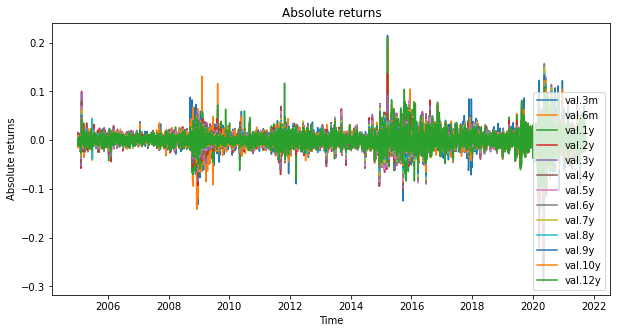

In [155]:

# absolute returns (easier to see daily changes)
df_returns  = pd.DataFrame(dates)
#df_returns = df_final.iloc[:,1:].map()
for col in range(1,nseries):
    absreturn = df_final.iloc[:,col].pct_change()
    df_returns.insert(col, df_final.columns[col], absreturn)

df_returns = df_returns.iloc[1:nrows-2 , :] #delete first and last row


#plot absolute returns
plt.figure(figsize=(10,5))
plt.plot(df_returns.iloc[:,0], df_returns.iloc[:,1:], label=df_returns.columns[1:])
plt.title('Absolute returns')
plt.ylabel("Absolute returns")
plt.xlabel("Time")
plt.legend()
plt.show()

# Principal Component Analysis

The principal component analysis is then used to identify common factors which are driving movements in these rates. Typically 3-5 factors are sufficient to explain dynamics of the yield curve.

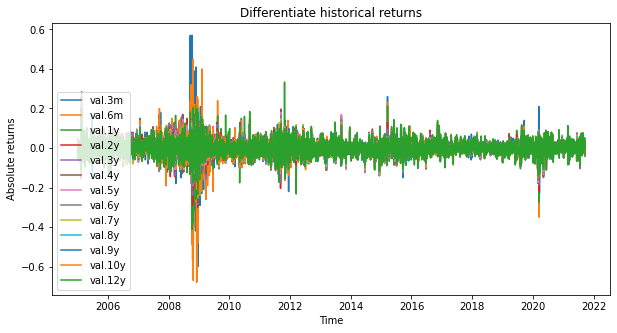

In [269]:
diff_rates = df_final.iloc[:,1:].diff( axis=0)
diff_rates = diff_rates.iloc[1:nrows-2,:] #delete first row

#plot absolute returns
plt.figure(figsize=(10,5))
plt.plot(df_returns.iloc[:,0], diff_rates, label=df_returns.columns[1:])
plt.title('Differentiated historical returns')
plt.ylabel("Absolute returns")
plt.xlabel("Time")
plt.legend()
plt.show()

In [184]:
#tenor refers to the time-to-maturity of a loan or other financial contract.
tenors = [3/12,6/12,1,2,3,4,5,6,7,8,9,10,12]
print(tenors)


[0.25, 0.5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12]


In [158]:
# Calculate covariance matrix
sigma = np.cov(diff_rates.transpose())
print("Sigma shape : " + str(sigma.shape))

Sigma shape : (13, 13)


In [159]:
#why?
sigma *= 252 #annulize daily rates

In [160]:
#calculate eigenvalues and vectors
eigval, eigvec = np.linalg.eig(sigma)
eigvec=np.matrix(eigvec)
print(eigval)

[2.83786424 0.84407195 0.17261726 0.10690237 0.06958162 0.03731521
 0.02389587 0.01401507 0.01108018 0.00341763 0.00416149 0.00608959
 0.00799918]


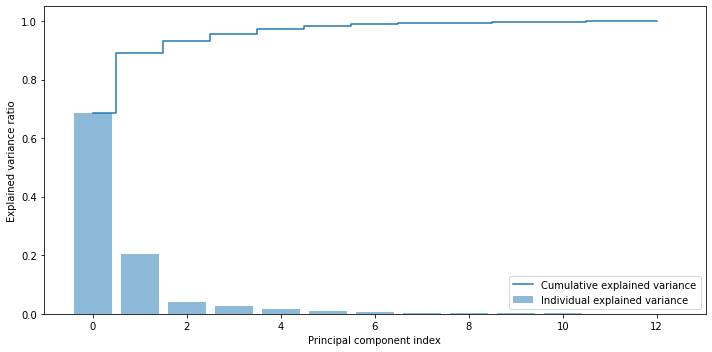

In [161]:
# Determine explained variance
total_eigval = sum(eigval)
var_exp = [(i/total_eigval) for i in sorted(eigval, reverse=True)]
var_exp

plt.figure(figsize=(10,5))
cum_sum_exp = np.cumsum(var_exp)
plt.bar(range(0,len(var_exp)), var_exp, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_exp)), cum_sum_exp, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Principal eigenvalues
[2.83786424 0.84407195 0.17261726]

Principal eigenvectors
[[ 0.13098485 -0.62882656  0.45827456]
 [ 0.15549992 -0.60027145  0.10886395]
 [ 0.18991312 -0.32523657 -0.44554222]
 [ 0.26329071 -0.12465822 -0.41654006]
 [ 0.29143884 -0.0448243  -0.35160764]
 [ 0.30393014  0.02177752 -0.22395381]
 [ 0.3116193   0.06659503 -0.10157399]
 [ 0.31465271  0.10074481  0.01760385]
 [ 0.31336537  0.12269711  0.11537901]
 [ 0.31124547  0.13863366  0.17747874]
 [ 0.30999885  0.15005037  0.2058022 ]
 [ 0.3099052   0.15292124  0.2396531 ]
 [ 0.30436588  0.16028431  0.27768685]]


Text(0.5, 0, 'Time $t$')

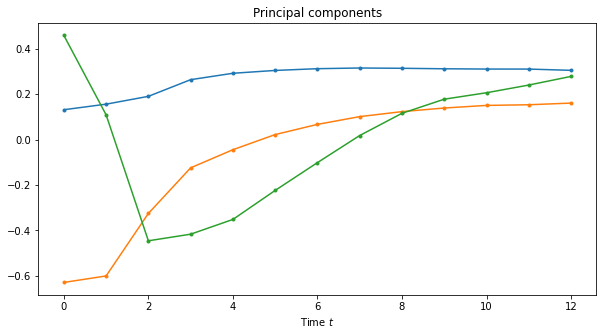

In [162]:
#select eigenvectors with highest eigenvalues
factors = 3 # 3 PCs
index_eigvec = list(reversed(eigval.argsort()))[0:factors]   # highest principal component first in the array
princ_eigval = np.array([eigval[i] for i in index_eigvec])
princ_comp = np.hstack([eigvec[:,i] for i in index_eigvec]) #hver PC eggges kolonnevis i princ_comp

#print results
print("Principal eigenvalues")
print(princ_eigval)
print()
print("Principal eigenvectors")
print(princ_comp)

#plot
plt.figure(figsize=(10,5))
plt.plot(princ_comp, marker='.')
plt.title('Principal components')
plt.xlabel(r'Time $t$')

vols shape: (13, 3)


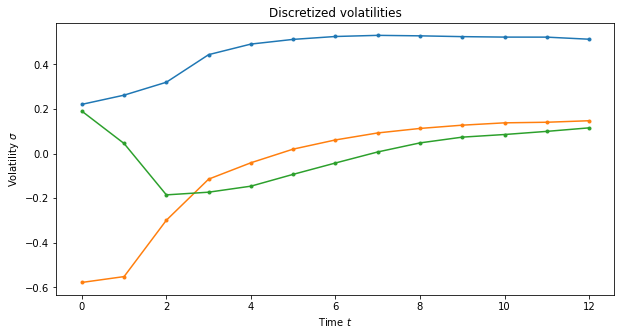

In [178]:
#Calculate discretized volatility function from principal components¶
sqrt_eigval = np.matrix(princ_eigval ** .5) #roten av egenverdier
tmp_m = np.vstack([sqrt_eigval for i in range(princ_comp.shape[0])])  # resize matrix og eigenvalues from (1,factors) to (n, factors)
vols = np.multiply(tmp_m, princ_comp) # multiply matrice element-wise
#print(princ_comp[0,0]*tmp_m[0,0]) #equivalent first element
print('vols shape: ' + str(vols.shape))

#plot
plt.figure(figsize=(10,5))
plt.plot(vols, marker='.')
plt.xlabel(r'Time $t$')
plt.ylabel(r'Volatility $\sigma$')
plt.title('Discretized volatilities');

# Volatility Fitting

Once the volatility factors are identified in historical data by PCA technique, cubic spline interpolator is used to fit these factors. These interpolators are then later used to generate discrete mesh of tenors for the purpose of Monte Carlo simulation.

We need to fit discretized volatility functions from the previous step using cubic interpolators. The reason is that these interpolators will be later integrated numerically in order to calculate risk-neutral drift.

In [216]:
def get_matrix_column(mat, i): #return given column from matrix
    return np.array(mat[:,i].flatten())[0]

class PolynomialInterpolator:
    
    def __init__(self, params):
        self.params = params

    def calc(self, x):
        n = len(self.params)
        C = self.params
        X = np.array([x**i for i in reversed(range(n))]) #matrix of polynomials of x
        return sum(np.multiply(X, C)) 

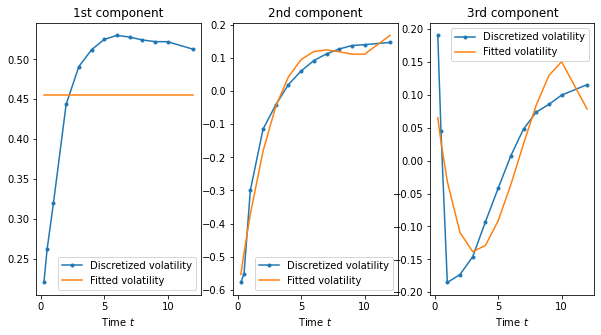

In [272]:
fitted_vols = []

def fit_volatility(i, degree, title): # i is giving index nr. of PC
    vol = get_matrix_column(vols, i)
    fitted_vol = PolynomialInterpolator(np.polyfit(tenors, vol, degree))    
    plt.plot(tenors, vol, marker='.', label='Discretized volatility')
    plt.plot(tenors, [fitted_vol.calc(x) for x in tenors], label='Fitted volatility')
    plt.title(title)
    plt.xlabel(r'Time $t$')
    plt.legend()
    fitted_vols.append(fitted_vol)



plt.figure(figsize=(10,5))
# We will approximate the first principal component with interpolator with 0 degree (straight line). This approximates well parallel movements of interest rates.   
plt.subplot(1, 3, 1)
fit_volatility(0, 0, '1st component')

# 2nd and 3rd principal component will be approximated using cubic interpolator with degree 3.
plt.subplot(1, 3, 2)
fit_volatility(1, 3, '2nd component')

plt.subplot(1, 3, 3)
fit_volatility(2, 3, '3rd component')


# Risk-neutral Drift Calculation

Drift function is calculated using numerical integration over fitted volatility function.
Define function for numeric integration. We will use trapezoidal rule.


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
[[ 0.45486822 -0.62322783  0.10537258]
 [ 0.45486822 -0.37032824 -0.03158954]
 [ 0.45486822 -0.18081815 -0.10935562]
 [ 0.45486822 -0.04587609 -0.13833512]
 [ 0.45486822  0.04331942 -0.12893755]
 [ 0.45486822  0.09558985 -0.09157237]
 [ 0.45486822  0.11975667 -0.03664909]
 [ 0.45486822  0.12464137  0.02542282]
 [ 0.45486822  0.11906541  0.08423387]
 [ 0.45486822  0.11185027  0.12937458]
 [ 0.45486822  0.11181743  0.15043545]
 [ 0.45486822  0.12778836  0.137007  ]
 [ 0.45486822  0.16858453  0.07867976]]


Text(0.5, 1.0, 'Volatilities')

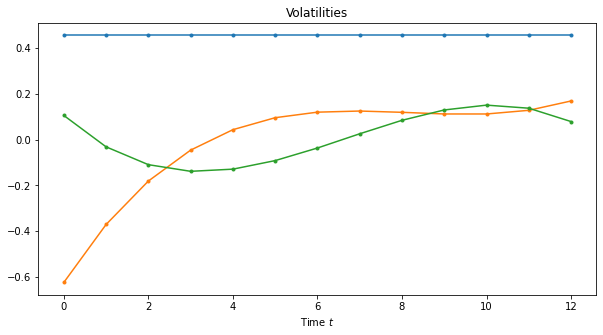

In [225]:
# Discretize fitted volatilities for the purpose of drift calculation
mc_tenors = np.linspace(0,12,13) #equally spaced points giving the tenors
print(mc_tenors)

# Discretize fitted volfuncs for the purpose of monte carlo simulation
mc_vols = np.matrix([[fitted_vol.calc(tenor) for tenor in mc_tenors] for fitted_vol in fitted_vols]).transpose()
print(mc_vols)


plt.figure(figsize=(10,5))
plt.plot(mc_tenors, mc_vols, marker='.')
plt.xlabel(r'Time $t$')
plt.title('Volatilities')

In [232]:
def integrate(f, x0, x1, dx):
    n = (x1-x0)/dx+1
    out = 0
    for i, x in enumerate(np.linspace(x0, x1, int(n))):
        if i==0 or i==n-1:
            out += 0.5 * f(x)
        else:
            out += f(x)  # not adjusted by *0.5 because of repeating terms x1...xn-1 - see trapezoidal rule
    out *= dx
    return out


def m(tau, fitted_vols):
    #This funciton carries out integration for all principal factors. 
    #It uses the fact that volatility is function of time in HJM model
    out = 0.
    for fitted_vol in fitted_vols:
        out += integrate(fitted_vol.calc, 0, tau, 0.01) * fitted_vol.calc(tau)
    return out

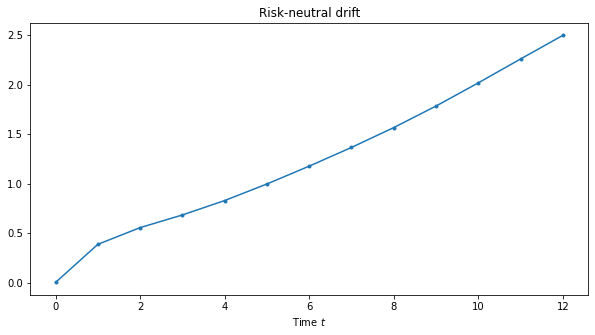

In [233]:
mc_drift = np.array([m(tau, fitted_vols) for tau in mc_tenors])

plt.figure(figsize=(10,5))
plt.plot(mc_drift, marker='.')
plt.xlabel(r'Time $t$')
plt.title('Risk-neutral drift');

# Monte Carlo Simulation

Monte Carlo Simulation with risk-neutral drift is used to generate evolution of yield curve for different simulation paths in order to price IR Caplet with strike 3%, expiring in one and maturing in two years.

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.]
[0.0 0.0 0.0 0.012455 0.014175 0.015125 0.015697000000000003 0.016083
 0.016364999999999998 0.016588000000000002 0.01675 0.016875 0.0]


Text(0.5, 0, '$T$')

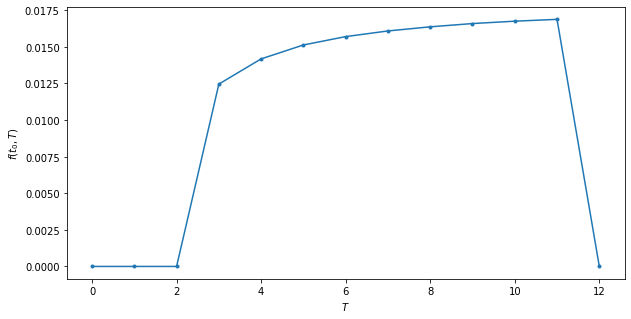

In [255]:
# today's instantenous forward rates
print(mc_tenors)
curve_spot = np.array(np.matrix(df_final.iloc[-1,1:]/100).flatten())[0]
print(curve_spot.transpose())

plt.figure(figsize=(10,5))
plt.plot(mc_tenors, curve_spot.transpose(), marker='.')
plt.ylabel('$f(t_0,T)$')
plt.xlabel("$T$")

In [265]:
import copy

def simulation(f, tenors, drift, vols, timeline):
    vols = np.array(vols.transpose())  # 3 rows, T columns
    len_tenors = len(tenors)
    len_vols = len(vols)
    yield timeline[0], copy.copy(f)

    for it in range(1, len(timeline)):                  # for hver x-verdi (dato i fremtiden)
        t = timeline[it]                                # t er ant. år frem i tid.
        dt = t - timeline[it-1]                         # tidsintervall fra sist iterasjon
        sqrt_dt = np.sqrt(dt)
        fprev = f
        f = copy.copy(f)
        random_numbers = [np.random.normal() for i in range(len_vols)]
        for iT in range(len_tenors):                        
            val = fprev[iT] + drift[iT] * dt
            #
            summ = 0
            for iVol, vol in enumerate(vols):
                summ += vol[iT] * random_numbers[iVol]
            val += summ * sqrt_dt
            #
            iT1 = iT+1 if iT < len_tenors-1 else iT-1   # if we can't take right difference, take left difference
            dfdT = (fprev[iT1] - fprev[iT]) / (iT1 - iT)
            val += dfdT * dt
            #
            f[iT] = val
        yield t,f

<generator object simulation at 0x123c77cf0>


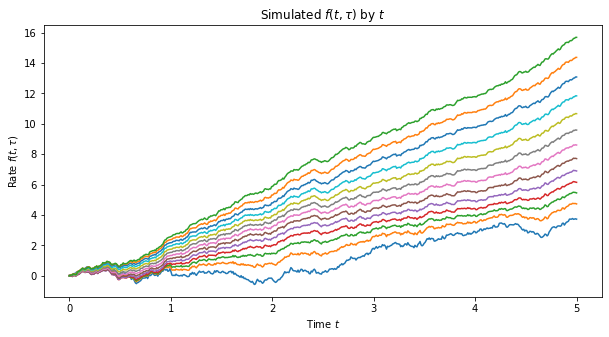

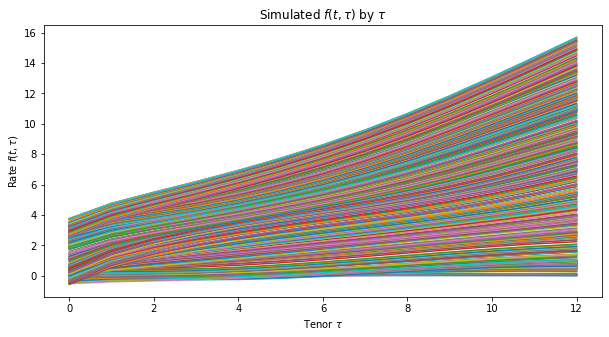

In [275]:
proj_rates = []
proj_timeline = np.linspace(0,5,500)


for i, (t, f) in enumerate(simulation(curve_spot, mc_tenors, mc_drift, mc_vols, proj_timeline)):
    proj_rates.append(f)

proj_rates = np.matrix(proj_rates)


plt.figure(figsize=(10,5))
plt.plot(proj_timeline.transpose(), proj_rates)
plt.xlabel(r'Time $t$')
plt.ylabel(r'Rate $f(t,\tau)$')
plt.title(r'Simulated $f(t,\tau)$ by $t$')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(mc_tenors, proj_rates.transpose())
plt.xlabel(r'Tenor $\tau$')
plt.ylabel(r'Rate $f(t,\tau)$')
plt.title(r'Simulated $f(t,\tau)$ by $\tau$')
plt.show()